# Question 1: [Index] S&P 500 Stocks Added to the Index

Which year had the highest number of additions?

Using the list of S&P 500 companies from Wikipedia's [S&P 500 companies page][wiki-page], download the data including the year each company was added to the index.

- Create a DataFrame with company tickers, names, and the year they were added.
- Extract the year from the addition date and calculate the number of stocks added each year.
- Which year had the highest number of additions (1957 doesn't count, as it was the year when the S&P 500 index was founded)? Write down this year as your answer (the most recent one, if you have several records).

Context:

>" Following the announcement, all four new entrants saw their stock prices rise in extended trading on Friday" - recent examples of S&P 500 additions include DASH, WSM, EXE, TKO in 2025 ([Nasdaq article][nasdaq-article]).

Additional: How many current S&P 500 stocks have been in the index for more than 20 years? When stocks are added to the S&P 500, they usually experience a price bump as investors and index funds buy shares following the announcement.

[wiki-page]: https://en.wikipedia.org/wiki/List_of_S%26P_500_companies
[nasdaq-article]: https://www.nasdaq.com/articles/sp-500-reshuffle-dash-tko-expe-wsm-join-worth-buying

In [1]:
from bs4 import BeautifulSoup
from datetime import date
from polars import col as c
import polars as pl
import requests as r

resp = r.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
doc = BeautifulSoup(resp.content, 'html.parser')
table = doc.find_all(id='constituents')[0]
headers = [str(h.get_text().strip()).lower() for h in table.find_all(name='th')]
rows = [
    [str(cell.get_text().strip()) for cell in row.find_all(name='td')]
    for row in table.find_all(name='tr')[1:]   # for some strange reasons, header row (tr > th) is the first row in  <tbody>
]
df = pl.DataFrame([dict(zip(headers, row)) for row in rows]).with_columns(
    year=c("date added").str.strptime(pl.Date, "%Y-%m-%d").dt.year()
).select('symbol', 'security', 'year')
df.head()

symbol,security,year
str,str,i32
"""MMM""","""3M""",1957
"""AOS""","""A. O. Smith""",2017
"""ABT""","""Abbott Laboratories""",1957
"""ABBV""","""AbbVie""",2012
"""ACN""","""Accenture""",2011


In [2]:
df.group_by('year').agg(
    num_additions=pl.first().filter(c('year') != 1957).count()
).sort(['num_additions', 'year'], descending=True).head()

year,num_additions
i32,u32
2017,23
2016,23
2019,22
2008,17
2024,16


For simplicity, only the (extracted) year component used to determine whether the company is on S&P 500 for more than 20 years.

In [3]:
df.filter(c('year') + 20 < date.today().year).select(pl.first().count()).item(0, 0)

219

# Question 2. [Macro] Indexes YTD (as of 1 May 2025)

How many indexes (out of 10) have better year-to-date returns than the US (S&P 500) as of May 1, 2025?

Using Yahoo Finance World Indices data, compare the year-to-date (YTD) performance (1 January-1 May 2025) of major stock market indexes for the following countries:

- United States - S&P 500 (^GSPC)
- China - Shanghai Composite (000001.SS)
- Hong Kong - HANG SENG INDEX (^HSI)
- Australia - S&P/ASX 200 (^AXJO)
- India - Nifty 50 (^NSEI)
- Canada - S&P/TSX Composite (^GSPTSE)
- Germany - DAX (^GDAXI)
- United Kingdom - FTSE 100 (^FTSE)
- Japan - Nikkei 225 (^N225)
- Mexico - IPC Mexico (^MXX)
- Brazil - Ibovespa (^BVSP)

Hint: use `start_date='2025-01-01'` and `end_date='2025-05-01'` when downloading daily data in yfinance

Context:

> [Global Valuations: Who's Cheap][global-valuations], Who's Not? article suggests "Other regions may be growing faster than the US and you need to diversify."

Reference: Yahoo Finance World Indices - https://finance.yahoo.com/world-indices/

Additional: How many of these indexes have better returns than the S&P 500 over 3, 5, and 10 year periods? Do you see the same trend? Note: For simplicity, ignore currency conversion effects.)

[global-valuations]: https://simplywall.st/article/beyond-the-us-global-markets-after-yet-another-tariff-update

In [4]:
import yfinance as yf
from pathlib import Path

def load_ohlc(index: str, start='2025-01-01', end='2025-05-01') -> pl.DataFrame:
    fname = Path.cwd() / f"{index[1:] if index.startswith('^') else index}-{start}-{end}.csv".lower()
    
    if fname.exists():
        df = pl.read_csv(fname).with_columns(Date=c('Date').str.slice(0, 10).str.strptime(pl.Date, '%Y-%m-%d'))
    else:
        df = pl.DataFrame(yf.Ticker(index).history(start=start, end=end).reset_index())
        df.write_csv(fname)   # cache the data to prevent API throttling problems during experimentations
    
    return df.sort('Date', descending=False)

def calculate_ytd_performance(df: pl.DataFrame) -> float:
    return df['Close'].item(-1) / df['Close'].item(0) - 1

Let's get the YTD performances for each index:

In [5]:
indices = {
    'United States - S&P 500': '^GSPC',
    'China - Shanghai Composite': '000001.SS',
    'Hong Kong - HANG SENG INDEX': '^HSI',
    'Australia - S&P/ASX 200': '^AXJO',
    'India - Nifty 50': '^NSEI',
    'Canada - S&P/TSX Composite': '^GSPTSE',
    'Germany - DAX': '^GDAXI',
    'United Kingdom - FTSE 100': '^FTSE',
    'Japan - Nikkei 225': '^N225',
    'Mexico - IPC Mexico': '^MXX',
    'Brazil - Ibovespa': '^BVSP'
}

df = pl.DataFrame([
    {'index': k, 'ytd-perf': calculate_ytd_performance(load_ohlc(v))}
    for k, v in indices.items()
])
df.sort('ytd-perf', descending=True)

index,ytd-perf
str,f64
"""Mexico - IPC Mexico""",0.130494
"""Hong Kong - HANG SENG INDEX""",0.1272
"""Brazil - Ibovespa""",0.124387
"""Germany - DAX""",0.123464
"""United Kingdom - FTSE 100""",0.028426
…,…
"""China - Shanghai Composite""",0.005048
"""Canada - S&P/TSX Composite""",-0.002261
"""Australia - S&P/ASX 200""",-0.009145


Then retrieve S&P 500's performance:

In [6]:
sp = 'United States - S&P 500'
sp_perf = df.filter(c('index') == sp).item(0, 1)
sp_perf

-0.05103300748245043

And finally, count the number of records in the dataframe that's filtered indices with better YTD performance: 

In [7]:
df.filter((c('index') != sp) & (c('ytd-perf') > sp_perf)).select(pl.first().count()).item(0, 0)

9

# Question 3. [Index] S&P 500 Market Corrections Analysis

Calculate the median duration (in days) of significant market corrections in the S&P 500 index.

For this task, define a correction as an event when a stock index goes down by more than 5% from the closest all-time high maximum.

Steps:

1. Download S&P 500 historical data (1950-present) using yfinance
2. Identify all-time high points (where price exceeds all previous prices)
3. For each pair of consecutive all-time highs, find the minimum price in between
4. Calculate drawdown percentages: (high - low) / high × 100
5. Filter for corrections with at least 5% drawdown
6. Calculate the duration in days for each correction period
7. Determine the 25th, 50th (median), and 75th percentiles for correction durations

Context:

> * Investors often wonder about the typical length of market corrections when deciding "when to buy the dip" ([Reddit discussion][reddit]).
> * [A Wealth of Common Sense - How Often Should You Expect a Stock Market Correction?][wealth-cs]

Hint (use this data to compare with your results): Here is the list of top 10 largest corrections by drawdown:

- 2007-10-09 to 2009-03-09: 56.8% drawdown over 517 days
- 2000-03-24 to 2002-10-09: 49.1% drawdown over 929 days
- 1973-01-11 to 1974-10-03: 48.2% drawdown over 630 days
- 1968-11-29 to 1970-05-26: 36.1% drawdown over 543 days
- 2020-02-19 to 2020-03-23: 33.9% drawdown over 33 days
- 1987-08-25 to 1987-12-04: 33.5% drawdown over 101 days
- 1961-12-12 to 1962-06-26: 28.0% drawdown over 196 days
- 1980-11-28 to 1982-08-12: 27.1% drawdown over 622 days
- 2022-01-03 to 2022-10-12: 25.4% drawdown over 282 days
- 1966-02-09 to 1966-10-07: 22.2% drawdown over 240 days

[reddit]: https://www.reddit.com/r/investing/comments/1jrqnte/when_are_you_buying_the_dip/?rdt=64135
[wealth-cs]: https://awealthofcommonsense.com/2022/01/how-often-should-you-expect-a-stock-market-correction/

In [8]:
from datetime import date

df = (
    load_ohlc('^GSPC', start='1950-01-01', end=str(date.today()))
).select('Date', 'Close')
df

Date,Close
date,f64
1950-01-03,16.66
1950-01-04,16.85
1950-01-05,16.93
1950-01-06,16.98
1950-01-09,17.08
…,…
2025-05-28,5888.549805
2025-05-29,5912.169922
2025-05-30,5911.689941


Let's visualize the data:

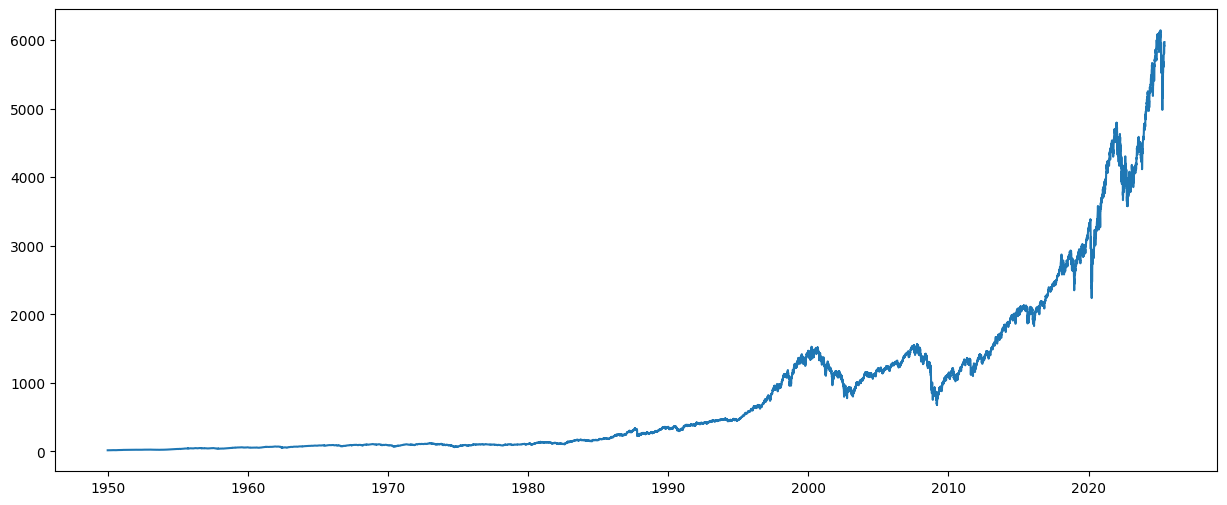

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Close']);

The line seems relatively flat before 1990; this is likely due to the smallish values for that period.
Let's "zoom" in to that period:

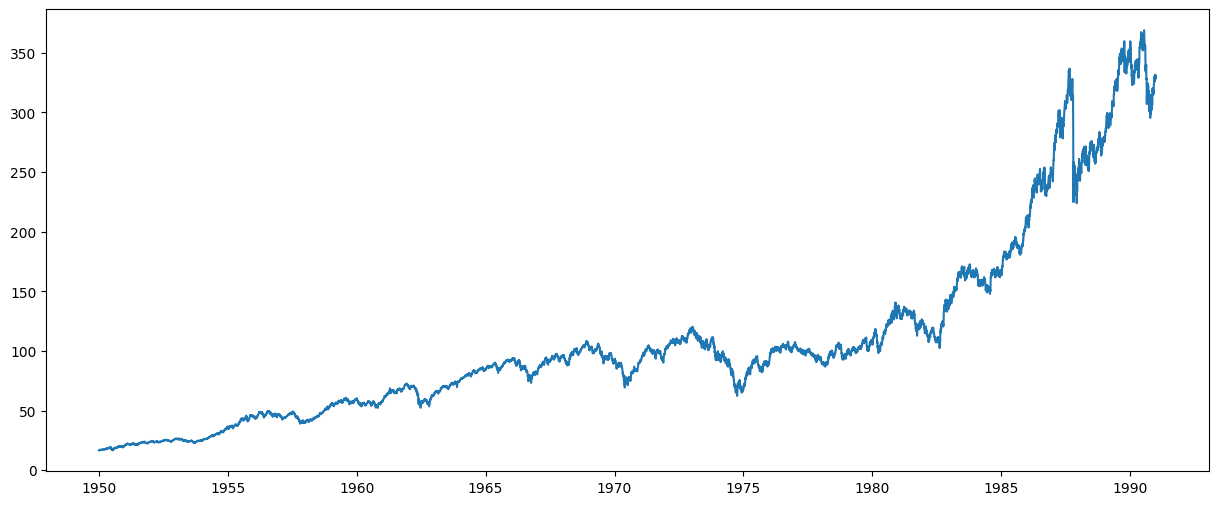

In [10]:
plt.figure(figsize=(15, 6))
pred = c('Date') < date(1990, 12, 31)
plt.plot(df.filter(pred)['Date'], df.filter(pred)['Close']);

As expected, between 1950 and 1990, there too were corrections.

In [11]:
(
    df.with_columns(peak=c('Close').cum_max())
    .group_by('peak')
    .agg(
        low=c('Close').min(),
        start_date=c('Date').first().dt.date(),
        low_date=(c('Date').filter(c('Close').min() == c('Close')).first()).dt.date(),
    )
    .with_columns(
        drawdown=(c('peak') - c('low')) / c('peak') * 100,
        duration=(c('low_date') - c('start_date')).dt.total_days(),
    )
    .filter(c('drawdown') >= 5)
    .sort('drawdown', descending=True)
).select(c('duration').median())

duration
f64
40.5


# Question 4. [Stocks] Earnings Surprise Analysis for Amazon (AMZN)

Calculate the median 2-day percentage change in stock prices following positive earnings surprises days.

Steps:

1. Load earnings data from CSV [ha1_Amazon.csv](./ha1_Amazon.csv) containing earnings dates, EPS estimates, and actual EPS.
   Make sure you are using the correct delimiter to read the data, such as in this command python
   `pandas.read_csv("ha1_Amazon.csv", delimiter=';')`
2. Download complete historical price data using yfinance
3. Calculate 2-day percentage changes for all historical dates: for each sequence of 3 consecutive trading
   days (Day 1, Day 2, Day 3), compute the return as Close_Day3 / Close_Day1 - 1. (Assume Day 2 may correspond to the
   earnings announcement.)
4. Identify positive earnings surprises (where "actual EPS > estimated EPS"). Both fields should be present in the file.
   You should obtain 36 data points for use in the descriptive analysis (median) later.
5. Calculate 2-day percentage changes following positive earnings surprises.
   Show your answer in % (closest number to the 2nd digit): `return * 100.0`
6. (Optional) Compare the median 2-day percentage change for positive surprises vs. all historical dates. Do you see the difference?

Context: Earnings announcements, especially when they exceed analyst expectations, can significantly impact stock prices in the short term.

Reference: Yahoo Finance earnings calendar - https://finance.yahoo.com/calendar/earnings?symbol=AMZN

_Additional_: Is there a correlation between the magnitude of the earnings surprise and the stock price reaction? Does the market react differently to earnings surprises during bull vs. bear markets?)

First, load the earnings data from the given csv:

In [12]:
earnings = (
    pl.read_csv(Path.cwd() / 'ha1_Amazon.csv', separator=';')
    .with_columns(
        Date=c('Earnings Date').str.split(' at').list.first().str.strptime(pl.Date, '%B %d, %Y'),
        eps_estimate=pl.when(c('EPS Estimate') == '-').then(pl.lit(None)).otherwise(c('EPS Estimate')).cast(pl.Float32, strict=False),
        reported_eps=pl.when(c('Reported EPS') == '-').then(pl.lit(None)).otherwise(c('Reported EPS')).cast(pl.Float32, strict=False),
    )
    .filter(c('eps_estimate').is_not_null())
    .select('Date', 'eps_estimate', 'reported_eps')
)
earnings

Date,eps_estimate,reported_eps
date,f32,f32
2024-04-30,0.83,0.98
2024-02-01,0.8,1.0
2023-10-26,0.58,0.94
2023-08-03,0.35,0.65
2023-04-27,0.21,0.31
…,…,…
2000-04-26,-0.02,-0.02
2000-02-02,-0.02,-0.03
1999-10-27,-0.01,-0.01


Then, download AMZN's historical prices and calculate the 2-day percentage changes:

In [13]:
amzn = (
    load_ohlc('AMZN', start='1997-01-01')
    .with_columns(
        Date=c('Date').cast(pl.Date),
        close_delta=(c('Close').shift(-2) / c('Close')) - 1
    )
)
amzn

Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,close_delta
date,f64,f64,f64,f64,i64,f64,f64,f64
1997-05-15,0.121875,0.125,0.096354,0.097917,1443120000,0.0,0.0,-0.127659
1997-05-16,0.098438,0.098958,0.085417,0.086458,294000000,0.0,0.0,-0.054211
1997-05-19,0.088021,0.088542,0.08125,0.085417,122136000,0.0,0.0,-0.164639
1997-05-20,0.086458,0.0875,0.081771,0.081771,109344000,0.0,0.0,-0.146494
1997-05-21,0.081771,0.082292,0.06875,0.071354,377064000,0.0,0.0,0.051097
…,…,…,…,…,…,…,…,…
2025-04-24,180.919998,186.740005,180.179993,186.539993,43763200,0.0,0.0,0.006219
2025-04-25,187.619995,189.940002,185.490005,188.990005,36414300,0.0,0.0,-0.008466
2025-04-28,190.110001,190.220001,184.889999,187.699997,33224700,0.0,0.0,-0.017475


Then, filter earnings where Actual EPS > EPS Estimate:

In [14]:
positive_surprises = earnings.filter(c('reported_eps') > c('eps_estimate'))
positive_surprises

Date,eps_estimate,reported_eps
date,f32,f32
2024-04-30,0.83,0.98
2024-02-01,0.8,1.0
2023-10-26,0.58,0.94
2023-08-03,0.35,0.65
2023-04-27,0.21,0.31
…,…,…
2011-01-27,0.04,0.05
2010-10-21,0.02,0.03
2009-01-29,0.02,0.03


Finally, calculate the median of the 2-day changes of those positive surprises:

In [15]:
(
    amzn.join(positive_surprises, on='Date', how='inner')
    .select(c('close_delta').median())
).item(0, 0) * 100

2.0103379657178566